# Camera position
One important role of the on-arm camera is to drive the manipulator on top of the arm in the space. For this job, camera must detect whether the arm is orthogonal wrt the panel or not. In case the arm is not in the right position, the algorithm must provide a center for the rotation and an angle.\
For this purpose we assume that the marker is in the same plane as the panel, that we know the size of the marker (useful to calculate the distance from the panel) and that the marker is square.\
Same results can be achieved by a round marker, can be checked if it is perfectly round or elliptical.

In [1]:
# Import libraries once
import numpy as np
import cv2
import cv2.aruco as aruco
import matplotlib.pyplot as plt
%run ../general-utility.ipynb

# Constant parameters used in Aruco methods
ARUCO_PARAMETERS = aruco.DetectorParameters_create()
ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_5X5_50)

Report datas from camera calibration, for now it will be a smartphone.

In [2]:
phone_camera_matrix = np.matrix([[1.12055622e+03, 0.00000000e+00, 2.83691118e+02],\
                                 [0.00000000e+00, 1.13040969e+03, 6.36980150e+02],\
                                 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
phone_dist_coefs = np.array([ 4.59103398e-01, -3.67204965e+00,  1.91186052e-03, -7.83898893e-03, 6.07110328e+00])

In [3]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

### Draw axis on marker
For the beginning it's useful to graphically visualize what's going on. We can draw cartesian axes on top of the marker.\
We will compute cartesian angles from the rotation matrix. This would be the data that will be provided to the arm controller. Angle relative to Z is the one that must be as small as possible.

In [4]:
def draw_axis_on_marker(img_path):
    queryImg = cv2.imread(img_path)
    grayQueryImg = cv2.cvtColor(queryImg, cv2.COLOR_BGR2GRAY)

    # Create a square on flat plane with dimension of 4,6 cm
    marker_square = np.float32([[0, 0, 0], [0, 4.6, 0], [4.6, 4.6, 0], [4.6, 0, 0]])
    # Array for drawing the 3 cartesian axes
    axis = np.float32([[3,0,0], [0,3,0], [0,0,3]]).reshape(-1,3)

    # Detect the marker and get the top-left corner
    # For semplicity we assume only one marker is present. In the challenge case there would be more than one
    # For now we don't have the exact marker type or marker position, so cannot made further assumptions
    corners, ids, _ = aruco.detectMarkers(queryImg, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

    if ids is not None and len(ids) >= 1:
        the_marker = corners[0]
        # Find the rotation and translation vectors
        ret, rvecs, tvecs = cv2.solvePnP(marker_square, the_marker[0], phone_camera_matrix, phone_dist_coefs)
        
        # Project axes points according to camera matrix and distortion coeff
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, phone_camera_matrix, phone_dist_coefs)
        # Draw axes in the corner of the marker
        drawnImg = draw(queryImg, the_marker[0], imgpts)
        
        # From rvecs compute the rotation matrix
        rotation_matrix = cv2.Rodrigues(rvecs)[0]
        # Get the Projection matrix
        P = np.hstack((rotation_matrix, tvecs))

        # Compute eulero angles in degree
        euler_angles_degrees = - cv2.decomposeProjectionMatrix(P)[6]
        euler_angles_radians = euler_angles_degrees * np.pi / 180
        print(euler_angles_degrees)

        return queryImg, drawnImg

[[-144.99493783]
 [   8.38947791]
 [  29.01229365]]


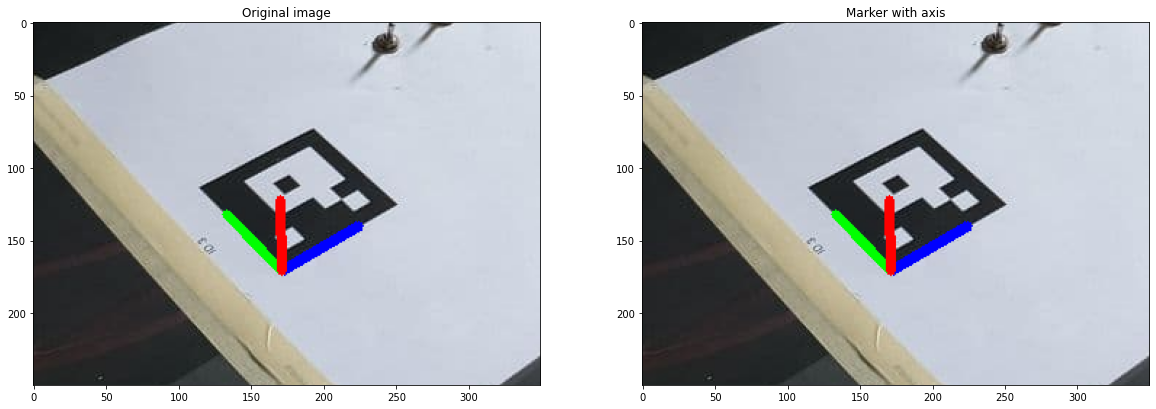

In [5]:
originalImg, drawnImg = draw_axis_on_marker("panel/panel-1.jpg")
show_two_imgs(originalImg[280:530, 350:700], "Original image", drawnImg[280:530, 350:700], "Marker with axis")

[[-177.07511411]
 [  -7.39894567]
 [  -2.01465459]]


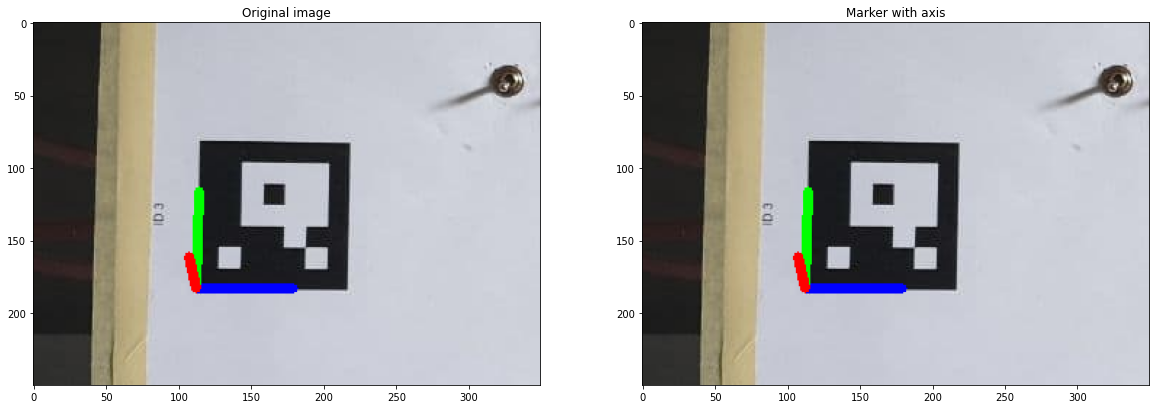

In [6]:
originalImg, drawnImg = draw_axis_on_marker("panel/panel-4.jpg")
show_two_imgs(originalImg[180:430, 250:600], "Original image", drawnImg[180:430, 250:600], "Marker with axis")

## Camera distance
Assuming we know the dimensions of the marker, square or circle, and the caracteristics of the camera mounted (in this example the smartphone), we can compute the distanca between the camera and the marker's plane.

In [9]:
def computeDistance(imgPath, debug=0):
    # ====== Camera parameters ==========
    # Sensor is 5.64mm wide
    # Original resolution is 4032x1960
    focal_lenght = 3558.572811
    # ====== End camera parameters ======

    # Size of the square marker
    marker_real_world_mm = 46

    queryImg = cv2.imread(imgPath)
    img_xy = queryImg.shape
    # Display the image, if portrait rotate to better visualize
    if debug:
        if np.argmax(img_xy) == 0:
            forDisplayImg = cv2.rotate(queryImg, cv2.ROTATE_90_CLOCKWISE)
        else:
            forDisplayImg = np.copy(queryImg)
        plt.figure(figsize=(20,10))
        plt.imshow(cv2.cvtColor(forDisplayImg, cv2.COLOR_BGR2RGB)), plt.title("Original image")
        plt.show()
        
    if debug: print("Image size:", img_xy)
    
    # Find the marker to compute the pixel width
    grayQueryImg = cv2.cvtColor(queryImg, cv2.COLOR_BGR2GRAY)
    corners, ids, _ = aruco.detectMarkers(queryImg, ARUCO_DICT, parameters=ARUCO_PARAMETERS)
    marker_dim_px = np.sqrt((corners[0][0][0][0] - corners[0][0][3][0])**2 + (corners[0][0][0][1] - corners[0][0][3][1])**2)
    if debug: print("Marker width in pixels:", marker_dim_px)
    
    distance_mm = marker_real_world_mm * (np.max(img_xy) / 4032) * focal_lenght / marker_dim_px
    if debug: print("Distance: {}cm".format(round(distance_mm / 10, 1)))
    return distance_mm

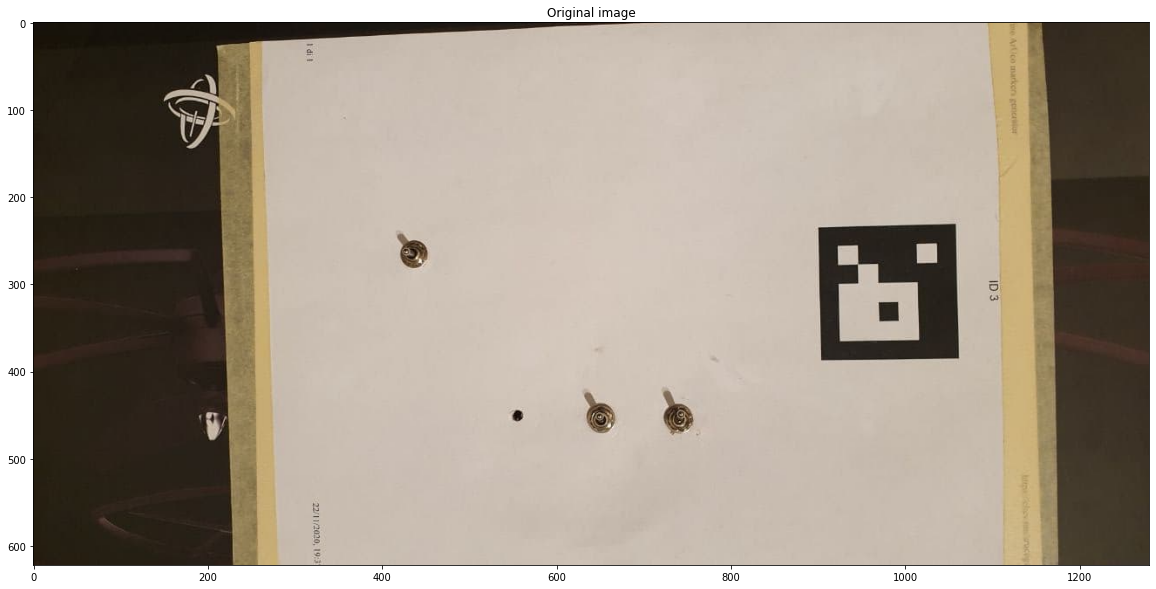

Image size: (1280, 622, 3)
Marker width in pixels: 155.08062419270823
Distance: 33.5cm


In [10]:
_ = computeDistance("panel/panel_34cm.jpg", debug=1)

The computed distance is 33.5cm, the actual distance was 34cm.

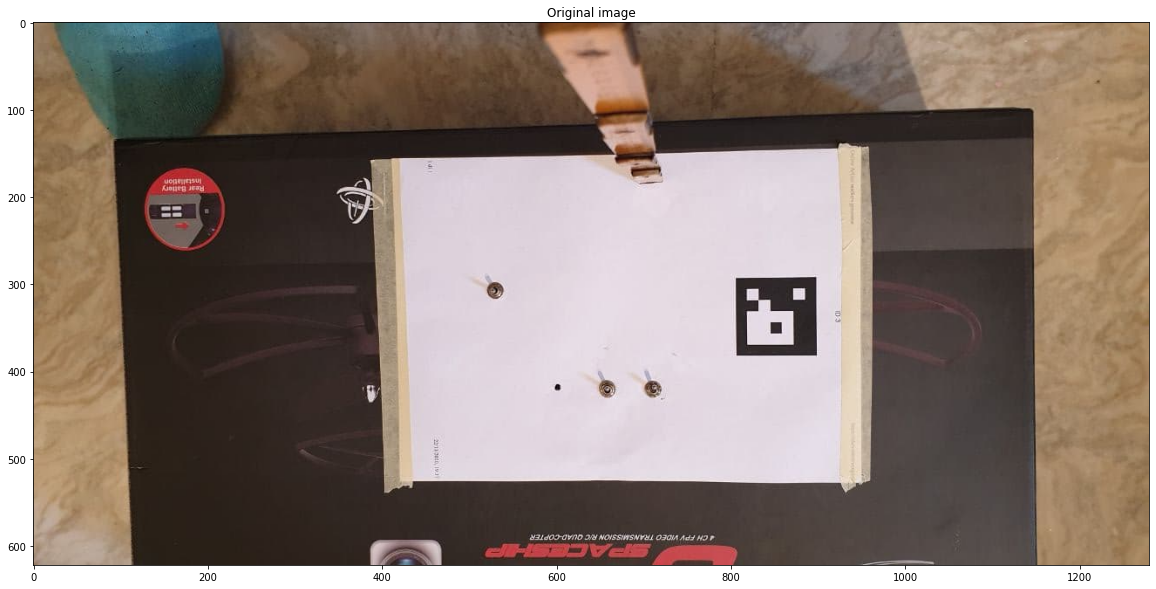

Image size: (1280, 622, 3)
Marker width in pixels: 91.00549433962765
Distance: 57.1cm


In [11]:
_ = computeDistance("panel/panel_57cm.jpg", debug=1)

The computed distance is 57.1cm, the actual distance was 57cm.

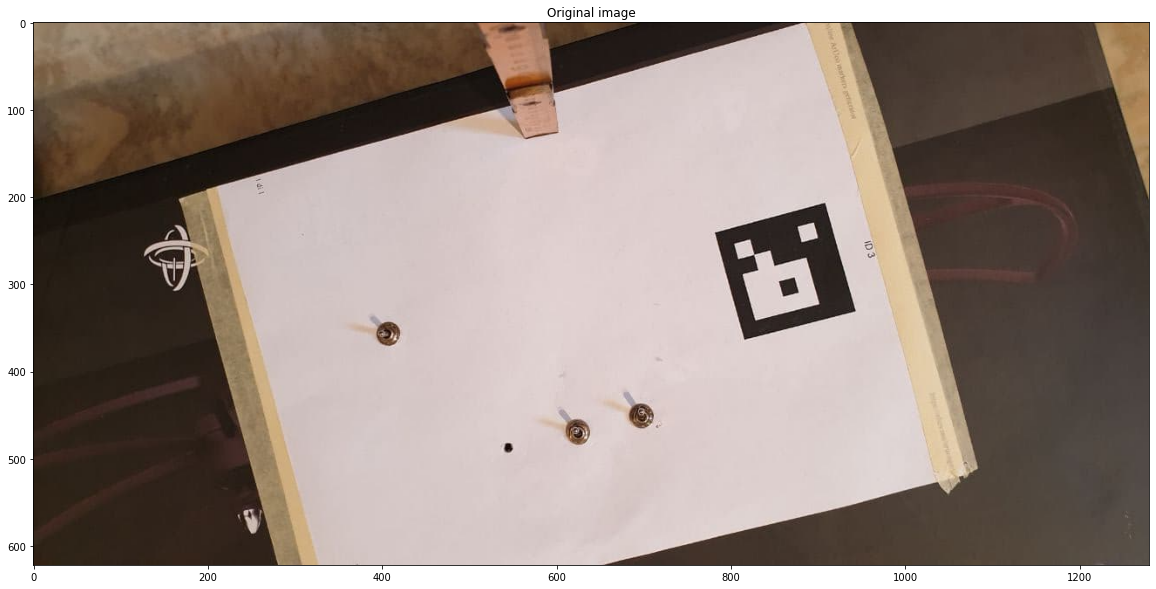

Image size: (1280, 622, 3)
Marker width in pixels: 127.88275880665071
Distance: 40.6cm


In [13]:
_ = computeDistance("panel/panel_40cm.jpg", debug=1)

The computed distance is 40.6cm, the actual distance was 40cm.

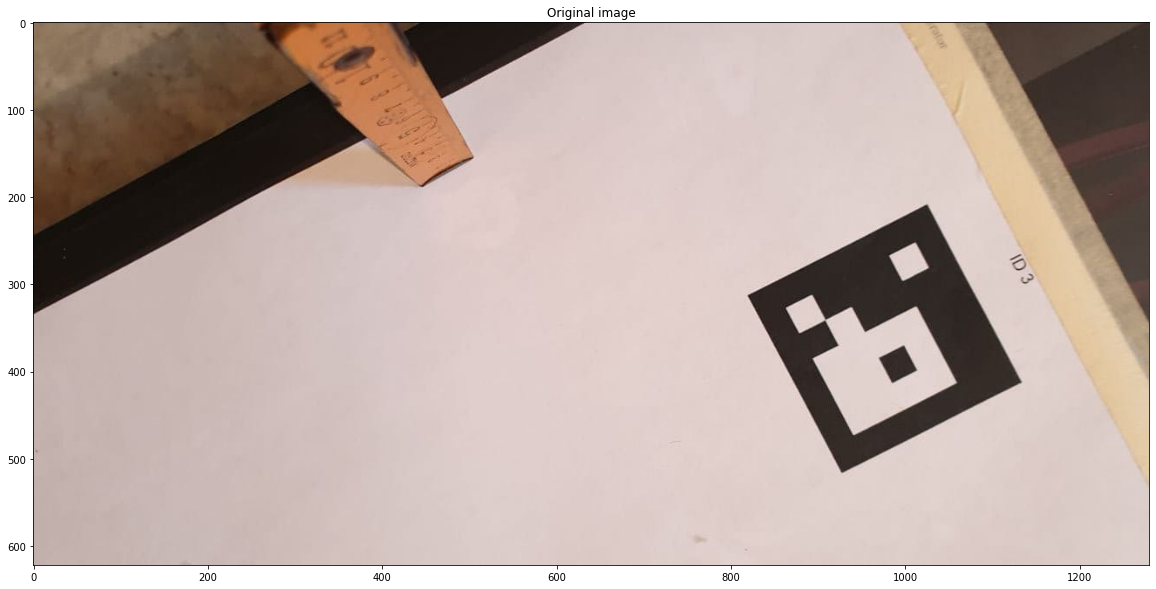

Image size: (1280, 622, 3)
Marker width in pixels: 217.8003673091485
Distance: 23.9cm


In [14]:
_ = computeDistance("panel/panel_23cm.jpg", debug=1)

The computed distance is 23.9cm, the actual distance was 23cm.

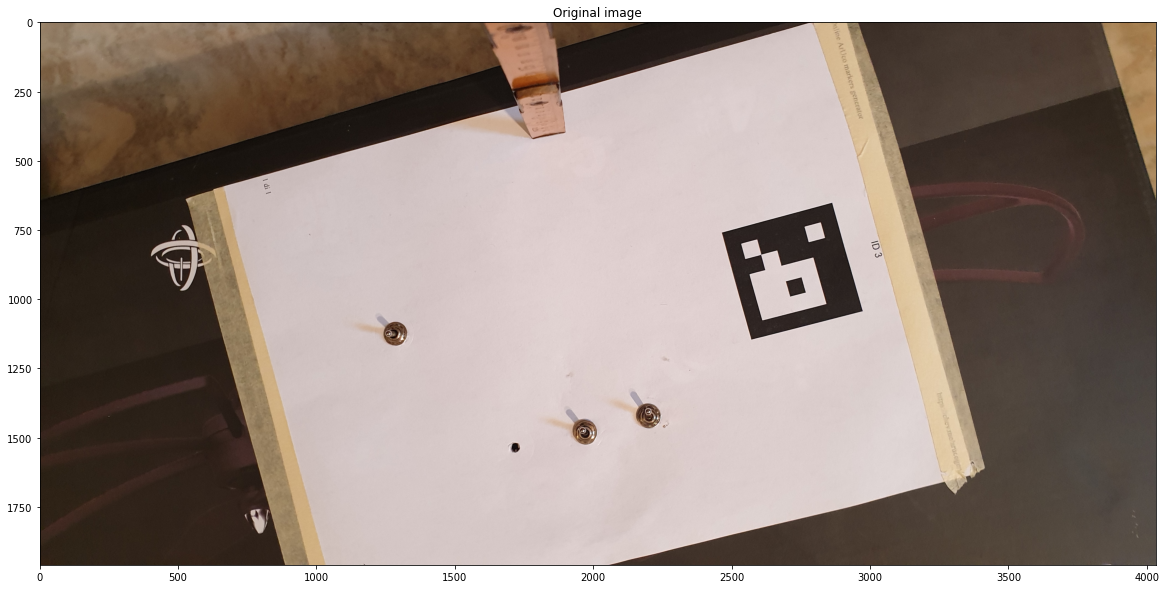

Image size: (4032, 1960, 3)
Pixel density: 714.8936170212767
Marker width in pixels: 409.2358733053592
Estimated FL*m: 3558.572811350949


NameError: name 'fl' is not defined

In [9]:
def getFocLenght(imgPath, distance_mm, debug=0):
    # ====== Camera parameters ==========
    focal_length_mm = 5.050656 # This value has been estrapolated from a picture taken with known distance
    # Sensor is 5.64mm wide
    # Original resolution is
    # Get pixel/mm of the sensor
    #m = 1125 / focal_length_mm
    m = 4032 / 5.64
    # ====== End camera parameters ======

    # Size of the square marker
    marker_real_world_mm = 46

    queryImg = cv2.imread(imgPath)
    img_xy = queryImg.shape
    # Display the image, if portrait rotate to better visualize
    if debug:
        if np.argmax(img_xy) == 0:
            forDisplayImg = cv2.rotate(queryImg, cv2.ROTATE_90_CLOCKWISE)
        else:
            forDisplayImg = np.copy(queryImg)
        plt.figure(figsize=(20,10))
        plt.imshow(cv2.cvtColor(forDisplayImg, cv2.COLOR_BGR2RGB)), plt.title("Original image")
        plt.show()
    
    if debug:
        print("Image size:", img_xy)
        print("Pixel density:", m)
    
    # Find the marker to compute the pixel width
    grayQueryImg = cv2.cvtColor(queryImg, cv2.COLOR_BGR2GRAY)
    corners, ids, _ = aruco.detectMarkers(queryImg, ARUCO_DICT, parameters=ARUCO_PARAMETERS)
    marker_dim_px = np.sqrt((corners[0][0][0][0] - corners[0][0][3][0])**2 + (corners[0][0][0][1] - corners[0][0][3][1])**2)
    if debug: print("Marker width in pixels:", marker_dim_px)
    
    flM = (distance_mm / marker_real_world_mm) * marker_dim_px * (4032 / np.max(img_xy))
    if debug: print("Estimated FL*m:", flM)
    return flM

getFocLenght("panel/panel_40cm_orig.jpg", distance_mm=400, debug=1)

In [ ]:
focal_lenght = 3558.572811

### Conclusion
It turns out that the distance provided by the camera is not so accurate. For our application it's useful to get a rough approximation until we enter in the range of other more accurate sensors, like laser or ultrasound sensors. If the panel is far away, we can make the arm move quicker and gain in time.\
Also it is important to enlight that the written algorithm consider an image with no inclination, or perhaps very little one. So before the estimation, the arm or the rover should be moved until the desired orientation is achieved.